<a href="https://colab.research.google.com/github/mfavaits/YouTube-Series-on-Machine-Learning/blob/master/Transfer_Learning_VGG16_with_Dropout_Dogs_vs_Cats_Small_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import os
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
conv_base = VGG16(weights= 'imagenet', include_top=False, input_shape=(150,150,3))
conv_base.summary ()

Using TensorFlow backend.






58892288/58889256 [==============================] - 1s 0us/step






Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
____________________________________________________

The final feature map has shape (4, 4, 512).
We extract features from by calling the predict method on the conv_base model

In [0]:
datagen=ImageDataGenerator(rescale=1./255)
batch_size=20

In [0]:
def extract_features(directory, sample_count): #extract features from a directory with JPEG files and sample_count is # files in dir
    features=np.zeros(shape=(sample_count, 4, 4, 512)) # empty array
    labels=np.zeros(shape=(sample_count)) # empty array
    generator=datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=20, class_mode='binary')
    
    i=0
    for inputs_batch, labels_batch in generator: 
      features_batch=conv_base.predict(inputs_batch) # extract features from conv_base
      features[i*batch_size:(i+1)*batch_size]=features_batch # for i=0 we have features[0:20], for i=2 features[20:40]
      labels[i*batch_size:(i+1)*batch_size]=labels_batch
      i+=1
      if i*batch_size>=sample_count:
        break #break when every image has been seen once
    return features, labels

In [9]:
train_features, train_labels = extract_features('/content/drive/My Drive/Colab Notebooks/training_2000', 2000)
validation_features, validation_labels = extract_features('/content/drive/My Drive/Colab Notebooks/val_1000', 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape (samples, 4 , 4, 512) and we need to flatten before pushing them through a densely connected layer

In [0]:
train_features=np.reshape(train_features, (2000, 4*4*512))
validation_features=np.reshape(validation_features, (1000, 4*4*512))

In [11]:
from keras import models
from keras import layers
from keras import optimizers

model=models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))



Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6113 - acc: 0.6625 - val_loss: 0.4440 - val_acc: 0.8330
Epoch 2/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.4438 - acc: 0.7965 - val_loss: 0.3694 - val_acc: 0.8470
Epoch 3/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3626 - acc: 0.8505 - val_loss: 0.3271 - val_acc: 0.8590
Epoch 4/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3239 - acc: 0.8695 - val_loss: 0.3054 - val_acc: 0.8660
Epoch 5/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2989 - acc: 0.8775 - val_loss: 0.2911 - val_acc: 0.8750
Epoch 6/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2746 - acc: 0.8910 - val_loss: 0.2851 - val_acc: 0.8740
Epoch 7/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2578 - acc: 0.8985 - val_loss: 0.2752 - val_acc: 0.8800
Epoch 8/30
2

In [0]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

In [0]:
epochs=range(1, len(acc)+1)

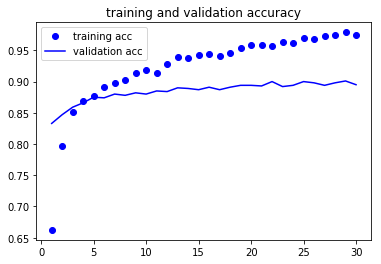

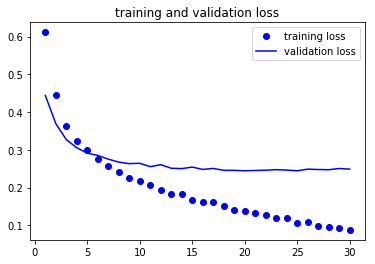

In [16]:
plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()